In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner

In [ ]:
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.toy_data import ToyData
from starccato_flow.training.trainer import Trainer
from starccato_flow.training.trainer_flow_matching import FlowMatchingTrainer

from starccato_flow.utils.defaults import TEN_KPC
from starccato_flow.plotting.plotting import plot_reconstruction_distribution, plot_candidate_signal, create_latent_morph_gif

/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

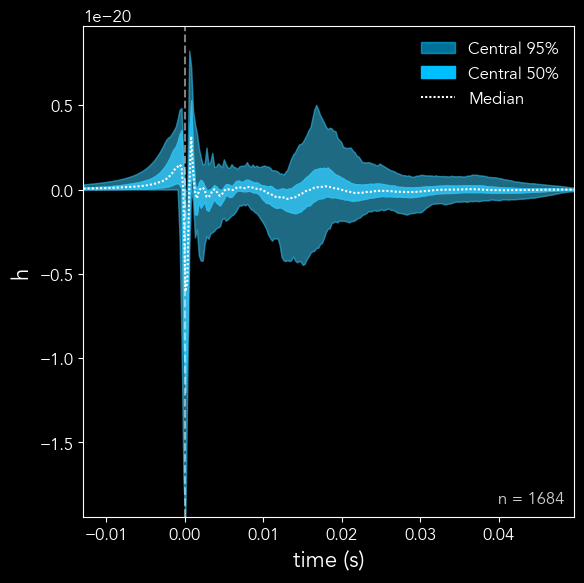

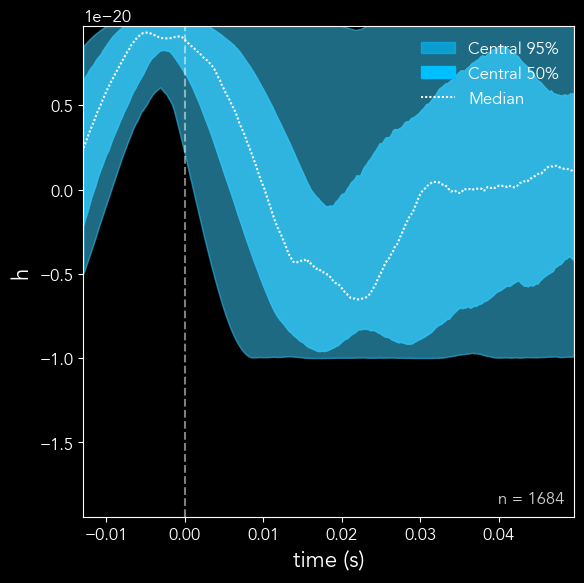

In [ ]:
ccsn_dataset = CCSNData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

toy_dataset = ToyData(noise=False, curriculum=False)
toy_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/toy_signal_distribution.svg")

In [5]:
trainer = FlowMatchingTrainer(
    toy=False, 
    num_epochs=512,
    start_snr=200,
    end_snr=10,
    noise=False, 
    validation_split=0.1,
    curriculum=False,
    noise_realizations=1
)

# trainer.plot_candidate_signal(
#     snr=30,
#     index=60,
#     background="black"
# )


=== Data Split (on base signals) ===
Total base signals: 1684
Training base signals: 1516
Validation base signals: 168
First 5 training indices: [ 360  336   81  684 1374]
First 5 validation indices: [722 519 222  32 111]
✓ Verification PASSED: No overlap between train and validation sets
  Train signals: 1516 unique indices
  Val signals: 168 unique indices
  Total coverage: 1684 / 1684

Verifying data alignment:
Number of signals: 1516
Number of parameter sets: 1516
Parameter columns: ['beta1_IC_b', 'omega_0(rad|s)', 'A(km)', 'Ye_c_b']
First few parameter values:
      beta1_IC_b  omega_0(rad|s)     A(km)   Ye_c_b
369     0.144352    2.140066e+00  6.146329  0.26472
345     0.121586    2.302585e+00  5.703782  0.26472
84      0.172129    2.525729e+00  5.703782  0.27792
708     0.001442    1.000000e-08  5.703782  0.28282
1447    0.047885    1.386294e+00  6.452049  0.28170

Verifying data alignment:
Number of signals: 168
Number of parameter sets: 168
Parameter columns: ['beta1_IC_b', '

In [6]:
trainer.train()

Epochs:   0%|          | 1/512 [00:03<26:20,  3.09s/it]

Epoch 1/512 | Train MSE Loss: 0.0401 | Val MSE Loss: 0.0474


Epochs:   0%|          | 2/512 [00:05<21:51,  2.57s/it]

Epoch 2/512 | Train MSE Loss: 0.0313 | Val MSE Loss: 0.0354


Epochs:   1%|          | 3/512 [00:07<20:34,  2.42s/it]

Epoch 3/512 | Train MSE Loss: 0.0294 | Val MSE Loss: 0.0332


Epochs:   1%|          | 4/512 [00:09<20:24,  2.41s/it]

Epoch 4/512 | Train MSE Loss: 0.0287 | Val MSE Loss: 0.0329


Epochs:   1%|          | 5/512 [00:12<19:41,  2.33s/it]

Epoch 5/512 | Train MSE Loss: 0.0275 | Val MSE Loss: 0.0339


Epochs:   1%|          | 6/512 [00:14<20:16,  2.40s/it]

Epoch 6/512 | Train MSE Loss: 0.0284 | Val MSE Loss: 0.0422


Epochs:   1%|▏         | 7/512 [00:16<19:37,  2.33s/it]

Epoch 7/512 | Train MSE Loss: 0.0274 | Val MSE Loss: 0.0416


Epochs:   2%|▏         | 8/512 [00:19<19:14,  2.29s/it]

Epoch 8/512 | Train MSE Loss: 0.0264 | Val MSE Loss: 0.0407


Epochs:   2%|▏         | 9/512 [00:21<18:48,  2.24s/it]

Epoch 9/512 | Train MSE Loss: 0.0272 | Val MSE Loss: 0.0397


Epochs:   2%|▏         | 10/512 [00:23<18:35,  2.22s/it]

Epoch 10/512 | Train MSE Loss: 0.0265 | Val MSE Loss: 0.0360


Epochs:   2%|▏         | 11/512 [00:25<18:22,  2.20s/it]

Epoch 11/512 | Train MSE Loss: 0.0257 | Val MSE Loss: 0.0394


Epochs:   2%|▏         | 12/512 [00:27<18:10,  2.18s/it]

Epoch 12/512 | Train MSE Loss: 0.0251 | Val MSE Loss: 0.0390


Epochs:   3%|▎         | 13/512 [00:29<18:17,  2.20s/it]

Epoch 13/512 | Train MSE Loss: 0.0248 | Val MSE Loss: 0.0365


Epochs:   3%|▎         | 14/512 [00:32<18:13,  2.20s/it]

Epoch 14/512 | Train MSE Loss: 0.0249 | Val MSE Loss: 0.0453


Epochs:   3%|▎         | 15/512 [00:34<18:19,  2.21s/it]

Epoch 15/512 | Train MSE Loss: 0.0250 | Val MSE Loss: 0.0413


Epochs:   3%|▎         | 16/512 [00:36<18:10,  2.20s/it]

Epoch 16/512 | Train MSE Loss: 0.0237 | Val MSE Loss: 0.0381


Epochs:   3%|▎         | 17/512 [00:38<18:14,  2.21s/it]

Epoch 17/512 | Train MSE Loss: 0.0240 | Val MSE Loss: 0.0373


Epochs:   4%|▎         | 18/512 [00:40<18:06,  2.20s/it]

Epoch 18/512 | Train MSE Loss: 0.0245 | Val MSE Loss: 0.0369


Epochs:   4%|▎         | 19/512 [00:43<18:00,  2.19s/it]

Epoch 19/512 | Train MSE Loss: 0.0233 | Val MSE Loss: 0.0364


Epochs:   4%|▍         | 20/512 [00:45<17:56,  2.19s/it]

Epoch 20/512 | Train MSE Loss: 0.0243 | Val MSE Loss: 0.0401


Epochs:   4%|▍         | 21/512 [00:47<17:52,  2.18s/it]

Epoch 21/512 | Train MSE Loss: 0.0230 | Val MSE Loss: 0.0409


Epochs:   4%|▍         | 22/512 [00:49<18:21,  2.25s/it]

Epoch 22/512 | Train MSE Loss: 0.0224 | Val MSE Loss: 0.0429


Epochs:   4%|▍         | 23/512 [00:51<18:01,  2.21s/it]

Epoch 23/512 | Train MSE Loss: 0.0226 | Val MSE Loss: 0.0385


Epochs:   5%|▍         | 24/512 [00:54<18:02,  2.22s/it]

Epoch 24/512 | Train MSE Loss: 0.0231 | Val MSE Loss: 0.0381


Epochs:   5%|▍         | 25/512 [00:56<18:39,  2.30s/it]

Epoch 25/512 | Train MSE Loss: 0.0226 | Val MSE Loss: 0.0428


Epochs:   5%|▌         | 26/512 [00:58<18:18,  2.26s/it]

Epoch 26/512 | Train MSE Loss: 0.0236 | Val MSE Loss: 0.0388


Epochs:   5%|▌         | 27/512 [01:01<18:00,  2.23s/it]

Epoch 27/512 | Train MSE Loss: 0.0222 | Val MSE Loss: 0.0482


Epochs:   5%|▌         | 28/512 [01:03<18:06,  2.25s/it]

Epoch 28/512 | Train MSE Loss: 0.0224 | Val MSE Loss: 0.0398


Epochs:   6%|▌         | 29/512 [01:05<18:16,  2.27s/it]

Epoch 29/512 | Train MSE Loss: 0.0220 | Val MSE Loss: 0.0333


Epochs:   6%|▌         | 30/512 [01:07<17:53,  2.23s/it]

Epoch 30/512 | Train MSE Loss: 0.0221 | Val MSE Loss: 0.0376


Epochs:   6%|▌         | 31/512 [01:10<18:22,  2.29s/it]

Epoch 31/512 | Train MSE Loss: 0.0212 | Val MSE Loss: 0.0346


Epochs:   6%|▋         | 32/512 [01:12<18:04,  2.26s/it]

Epoch 32/512 | Train MSE Loss: 0.0223 | Val MSE Loss: 0.0405


Epochs:   6%|▋         | 33/512 [01:14<18:29,  2.32s/it]

Epoch 33/512 | Train MSE Loss: 0.0221 | Val MSE Loss: 0.0398


Epochs:   7%|▋         | 34/512 [01:16<17:57,  2.25s/it]

Epoch 34/512 | Train MSE Loss: 0.0216 | Val MSE Loss: 0.0415


Epochs:   7%|▋         | 35/512 [01:19<17:46,  2.24s/it]

Epoch 35/512 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0397


Epochs:   7%|▋         | 36/512 [01:21<17:32,  2.21s/it]

Epoch 36/512 | Train MSE Loss: 0.0221 | Val MSE Loss: 0.0362


Epochs:   7%|▋         | 37/512 [01:23<17:24,  2.20s/it]

Epoch 37/512 | Train MSE Loss: 0.0221 | Val MSE Loss: 0.0419


Epochs:   7%|▋         | 38/512 [01:25<17:15,  2.18s/it]

Epoch 38/512 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0350


Epochs:   8%|▊         | 39/512 [01:27<17:10,  2.18s/it]

Epoch 39/512 | Train MSE Loss: 0.0213 | Val MSE Loss: 0.0362


Epochs:   8%|▊         | 40/512 [01:29<17:04,  2.17s/it]

Epoch 40/512 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0408


Epochs:   8%|▊         | 41/512 [01:32<17:01,  2.17s/it]

Epoch 41/512 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0356


Epochs:   8%|▊         | 42/512 [01:34<17:00,  2.17s/it]

Epoch 42/512 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0403


Epochs:   8%|▊         | 43/512 [01:36<17:10,  2.20s/it]

Epoch 43/512 | Train MSE Loss: 0.0211 | Val MSE Loss: 0.0407


Epochs:   9%|▊         | 44/512 [01:38<17:02,  2.18s/it]

Epoch 44/512 | Train MSE Loss: 0.0220 | Val MSE Loss: 0.0384


Epochs:   9%|▉         | 45/512 [01:40<16:57,  2.18s/it]

Epoch 45/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0341


Epochs:   9%|▉         | 46/512 [01:43<17:44,  2.28s/it]

Epoch 46/512 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0433


Epochs:   9%|▉         | 47/512 [01:45<17:32,  2.26s/it]

Epoch 47/512 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0361


Epochs:   9%|▉         | 48/512 [01:47<17:21,  2.25s/it]

Epoch 48/512 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0423


Epochs:  10%|▉         | 49/512 [01:49<17:11,  2.23s/it]

Epoch 49/512 | Train MSE Loss: 0.0210 | Val MSE Loss: 0.0417


Epochs:  10%|▉         | 50/512 [01:52<17:10,  2.23s/it]

Epoch 50/512 | Train MSE Loss: 0.0205 | Val MSE Loss: 0.0410


Epochs:  10%|▉         | 51/512 [01:54<17:02,  2.22s/it]

Epoch 51/512 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0383


Epochs:  10%|█         | 52/512 [01:56<16:49,  2.19s/it]

Epoch 52/512 | Train MSE Loss: 0.0207 | Val MSE Loss: 0.0388


Epochs:  10%|█         | 53/512 [01:59<17:30,  2.29s/it]

Epoch 53/512 | Train MSE Loss: 0.0216 | Val MSE Loss: 0.0365


Epochs:  11%|█         | 54/512 [02:01<17:18,  2.27s/it]

Epoch 54/512 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0418


Epochs:  11%|█         | 55/512 [02:03<17:23,  2.28s/it]

Epoch 55/512 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0481


Epochs:  11%|█         | 56/512 [02:05<17:07,  2.25s/it]

Epoch 56/512 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0421


Epochs:  11%|█         | 57/512 [02:08<17:11,  2.27s/it]

Epoch 57/512 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0472


Epochs:  11%|█▏        | 58/512 [02:10<16:54,  2.23s/it]

Epoch 58/512 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0441


Epochs:  12%|█▏        | 59/512 [02:12<16:43,  2.22s/it]

Epoch 59/512 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0376


Epochs:  12%|█▏        | 60/512 [02:14<16:44,  2.22s/it]

Epoch 60/512 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0399


Epochs:  12%|█▏        | 61/512 [02:17<17:01,  2.27s/it]

Epoch 61/512 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0412


Epochs:  12%|█▏        | 62/512 [02:19<16:50,  2.25s/it]

Epoch 62/512 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0469


Epochs:  12%|█▏        | 63/512 [02:21<16:32,  2.21s/it]

Epoch 63/512 | Train MSE Loss: 0.0209 | Val MSE Loss: 0.0398


Epochs:  12%|█▎        | 64/512 [02:23<16:23,  2.20s/it]

Epoch 64/512 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0477


Epochs:  13%|█▎        | 65/512 [02:25<16:20,  2.19s/it]

Epoch 65/512 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0424


Epochs:  13%|█▎        | 66/512 [02:28<16:37,  2.24s/it]

Epoch 66/512 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0506


Epochs:  13%|█▎        | 67/512 [02:30<16:26,  2.22s/it]

Epoch 67/512 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0473


Epochs:  13%|█▎        | 68/512 [02:32<16:25,  2.22s/it]

Epoch 68/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0394


Epochs:  13%|█▎        | 69/512 [02:34<16:44,  2.27s/it]

Epoch 69/512 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0468


Epochs:  14%|█▎        | 70/512 [02:37<16:40,  2.26s/it]

Epoch 70/512 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0555


Epochs:  14%|█▍        | 71/512 [02:39<17:58,  2.45s/it]

Epoch 71/512 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0437


Epochs:  14%|█▍        | 72/512 [02:42<18:39,  2.54s/it]

Epoch 72/512 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0434


Epochs:  14%|█▍        | 73/512 [02:45<18:17,  2.50s/it]

Epoch 73/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0466


Epochs:  14%|█▍        | 74/512 [02:47<17:54,  2.45s/it]

Epoch 74/512 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0482


Epochs:  15%|█▍        | 75/512 [02:49<17:28,  2.40s/it]

Epoch 75/512 | Train MSE Loss: 0.0196 | Val MSE Loss: 0.0487


Epochs:  15%|█▍        | 76/512 [02:51<16:52,  2.32s/it]

Epoch 76/512 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0389


Epochs:  15%|█▌        | 77/512 [02:54<16:49,  2.32s/it]

Epoch 77/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0396


Epochs:  15%|█▌        | 78/512 [02:56<16:28,  2.28s/it]

Epoch 78/512 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0495


Epochs:  15%|█▌        | 79/512 [02:58<16:25,  2.28s/it]

Epoch 79/512 | Train MSE Loss: 0.0199 | Val MSE Loss: 0.0602


Epochs:  16%|█▌        | 80/512 [03:01<16:37,  2.31s/it]

Epoch 80/512 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0574


Epochs:  16%|█▌        | 81/512 [03:03<16:34,  2.31s/it]

Epoch 81/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0468


Epochs:  16%|█▌        | 82/512 [03:06<17:28,  2.44s/it]

Epoch 82/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0529


Epochs:  16%|█▌        | 83/512 [03:08<16:27,  2.30s/it]

Epoch 83/512 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0438


Epochs:  16%|█▋        | 84/512 [03:10<16:14,  2.28s/it]

Epoch 84/512 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0492


Epochs:  17%|█▋        | 85/512 [03:12<15:58,  2.24s/it]

Epoch 85/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0416


Epochs:  17%|█▋        | 86/512 [03:14<15:56,  2.25s/it]

Epoch 86/512 | Train MSE Loss: 0.0199 | Val MSE Loss: 0.0446


Epochs:  17%|█▋        | 87/512 [03:17<16:06,  2.27s/it]

Epoch 87/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0576


Epochs:  17%|█▋        | 88/512 [03:19<15:53,  2.25s/it]

Epoch 88/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0451


Epochs:  17%|█▋        | 89/512 [03:21<15:51,  2.25s/it]

Epoch 89/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0497


Epochs:  18%|█▊        | 90/512 [03:23<15:39,  2.23s/it]

Epoch 90/512 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0499


Epochs:  18%|█▊        | 91/512 [03:25<15:35,  2.22s/it]

Epoch 91/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0499


Epochs:  18%|█▊        | 92/512 [03:27<15:24,  2.20s/it]

Epoch 92/512 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0537


Epochs:  18%|█▊        | 93/512 [03:30<15:20,  2.20s/it]

Epoch 93/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0472


Epochs:  18%|█▊        | 94/512 [03:32<15:10,  2.18s/it]

Epoch 94/512 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0460


Epochs:  19%|█▊        | 95/512 [03:34<15:18,  2.20s/it]

Epoch 95/512 | Train MSE Loss: 0.0199 | Val MSE Loss: 0.0464


Epochs:  19%|█▉        | 96/512 [03:36<15:09,  2.19s/it]

Epoch 96/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0588


Epochs:  19%|█▉        | 97/512 [03:38<15:13,  2.20s/it]

Epoch 97/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0478


Epochs:  19%|█▉        | 98/512 [03:41<16:12,  2.35s/it]

Epoch 98/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0505


Epochs:  19%|█▉        | 99/512 [03:44<16:39,  2.42s/it]

Epoch 99/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0585


Epochs:  20%|█▉        | 100/512 [03:46<16:14,  2.37s/it]

Epoch 100/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0631


Epochs:  20%|█▉        | 101/512 [03:48<16:19,  2.38s/it]

Epoch 101/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0650


Epochs:  20%|█▉        | 102/512 [03:51<16:45,  2.45s/it]

Epoch 102/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0621


Epochs:  20%|██        | 103/512 [03:53<16:46,  2.46s/it]

Epoch 103/512 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0531


Epochs:  20%|██        | 104/512 [03:56<17:01,  2.50s/it]

Epoch 104/512 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0468


Epochs:  21%|██        | 105/512 [03:58<16:18,  2.40s/it]

Epoch 105/512 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0417


Epochs:  21%|██        | 106/512 [04:01<16:10,  2.39s/it]

Epoch 106/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0459


Epochs:  21%|██        | 107/512 [04:03<16:25,  2.43s/it]

Epoch 107/512 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0562


Epochs:  21%|██        | 108/512 [04:05<15:34,  2.31s/it]

Epoch 108/512 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0452


Epochs:  21%|██▏       | 109/512 [04:07<14:58,  2.23s/it]

Epoch 109/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0503


Epochs:  21%|██▏       | 110/512 [04:09<14:24,  2.15s/it]

Epoch 110/512 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0475


Epochs:  22%|██▏       | 111/512 [04:11<14:37,  2.19s/it]

Epoch 111/512 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0545


Epochs:  22%|██▏       | 112/512 [04:14<14:41,  2.20s/it]

Epoch 112/512 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0460


Epochs:  22%|██▏       | 113/512 [04:16<14:22,  2.16s/it]

Epoch 113/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0513


Epochs:  22%|██▏       | 114/512 [04:18<14:05,  2.12s/it]

Epoch 114/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0595


Epochs:  22%|██▏       | 115/512 [04:20<13:59,  2.12s/it]

Epoch 115/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0591


Epochs:  23%|██▎       | 116/512 [04:22<13:59,  2.12s/it]

Epoch 116/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0491


Epochs:  23%|██▎       | 117/512 [04:24<14:10,  2.15s/it]

Epoch 117/512 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0573


Epochs:  23%|██▎       | 118/512 [04:26<13:56,  2.12s/it]

Epoch 118/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0389


Epochs:  23%|██▎       | 119/512 [04:29<14:09,  2.16s/it]

Epoch 119/512 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0523


Epochs:  23%|██▎       | 120/512 [04:31<14:04,  2.15s/it]

Epoch 120/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0596


Epochs:  24%|██▎       | 121/512 [04:33<13:34,  2.08s/it]

Epoch 121/512 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0637


Epochs:  24%|██▍       | 122/512 [04:35<13:45,  2.12s/it]

Epoch 122/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0750


Epochs:  24%|██▍       | 123/512 [04:37<13:43,  2.12s/it]

Epoch 123/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0490


Epochs:  24%|██▍       | 124/512 [04:39<13:30,  2.09s/it]

Epoch 124/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0703


Epochs:  24%|██▍       | 125/512 [04:41<13:37,  2.11s/it]

Epoch 125/512 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0515


Epochs:  25%|██▍       | 126/512 [04:43<13:25,  2.09s/it]

Epoch 126/512 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0745


Epochs:  25%|██▍       | 127/512 [04:45<13:06,  2.04s/it]

Epoch 127/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0626


Epochs:  25%|██▌       | 128/512 [04:47<13:19,  2.08s/it]

Epoch 128/512 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0547


Epochs:  25%|██▌       | 129/512 [04:49<13:27,  2.11s/it]

Epoch 129/512 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0655


Epochs:  25%|██▌       | 130/512 [04:51<12:59,  2.04s/it]

Epoch 130/512 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0641


Epochs:  26%|██▌       | 131/512 [04:53<12:47,  2.02s/it]

Epoch 131/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0777


Epochs:  26%|██▌       | 132/512 [04:55<12:49,  2.03s/it]

Epoch 132/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0721


Epochs:  26%|██▌       | 133/512 [04:58<13:06,  2.08s/it]

Epoch 133/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0572


Epochs:  26%|██▌       | 134/512 [05:00<13:53,  2.21s/it]

Epoch 134/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0617


Epochs:  26%|██▋       | 135/512 [05:02<13:51,  2.20s/it]

Epoch 135/512 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0676


Epochs:  27%|██▋       | 136/512 [05:04<13:33,  2.16s/it]

Epoch 136/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0680


Epochs:  27%|██▋       | 137/512 [05:06<13:20,  2.14s/it]

Epoch 137/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0678


Epochs:  27%|██▋       | 138/512 [05:08<13:08,  2.11s/it]

Epoch 138/512 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0526


Epochs:  27%|██▋       | 139/512 [05:11<14:03,  2.26s/it]

Epoch 139/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0688


Epochs:  27%|██▋       | 140/512 [05:13<13:52,  2.24s/it]

Epoch 140/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0689


Epochs:  28%|██▊       | 141/512 [05:15<13:38,  2.21s/it]

Epoch 141/512 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0622


Epochs:  28%|██▊       | 142/512 [05:17<13:13,  2.14s/it]

Epoch 142/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0587


Epochs:  28%|██▊       | 143/512 [05:19<12:51,  2.09s/it]

Epoch 143/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0539


Epochs:  28%|██▊       | 144/512 [05:21<12:30,  2.04s/it]

Epoch 144/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0516


Epochs:  28%|██▊       | 145/512 [05:23<12:38,  2.07s/it]

Epoch 145/512 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0725


Epochs:  29%|██▊       | 146/512 [05:25<12:19,  2.02s/it]

Epoch 146/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0641


Epochs:  29%|██▊       | 147/512 [05:27<12:03,  1.98s/it]

Epoch 147/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0632


Epochs:  29%|██▉       | 148/512 [05:29<11:52,  1.96s/it]

Epoch 148/512 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0840


Epochs:  29%|██▉       | 149/512 [05:31<11:39,  1.93s/it]

Epoch 149/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0543


Epochs:  29%|██▉       | 150/512 [05:33<11:33,  1.91s/it]

Epoch 150/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0652


Epochs:  29%|██▉       | 151/512 [05:35<11:33,  1.92s/it]

Epoch 151/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0655


Epochs:  30%|██▉       | 152/512 [05:37<11:32,  1.92s/it]

Epoch 152/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0642


Epochs:  30%|██▉       | 153/512 [05:39<11:45,  1.96s/it]

Epoch 153/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0544


Epochs:  30%|███       | 154/512 [05:41<11:37,  1.95s/it]

Epoch 154/512 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0609


Epochs:  30%|███       | 155/512 [05:43<11:31,  1.94s/it]

Epoch 155/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0633


Epochs:  30%|███       | 156/512 [05:45<11:40,  1.97s/it]

Epoch 156/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0545


Epochs:  31%|███       | 157/512 [05:47<11:33,  1.95s/it]

Epoch 157/512 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0613


Epochs:  31%|███       | 158/512 [05:49<11:48,  2.00s/it]

Epoch 158/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0652


Epochs:  31%|███       | 159/512 [05:51<12:29,  2.12s/it]

Epoch 159/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0670


Epochs:  31%|███▏      | 160/512 [05:53<12:09,  2.07s/it]

Epoch 160/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0721


Epochs:  31%|███▏      | 161/512 [05:55<12:04,  2.07s/it]

Epoch 161/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0596


Epochs:  32%|███▏      | 162/512 [05:57<12:05,  2.07s/it]

Epoch 162/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0608


Epochs:  32%|███▏      | 163/512 [06:00<12:41,  2.18s/it]

Epoch 163/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0753


Epochs:  32%|███▏      | 164/512 [06:02<12:16,  2.12s/it]

Epoch 164/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0666


Epochs:  32%|███▏      | 165/512 [06:03<11:51,  2.05s/it]

Epoch 165/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0671


Epochs:  32%|███▏      | 166/512 [06:06<13:01,  2.26s/it]

Epoch 166/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0807


Epochs:  33%|███▎      | 167/512 [06:12<19:43,  3.43s/it]

Epoch 167/512 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0610


Epochs:  33%|███▎      | 168/512 [06:15<18:05,  3.16s/it]

Epoch 168/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0526


Epochs:  33%|███▎      | 169/512 [06:18<18:01,  3.15s/it]

Epoch 169/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0479


Epochs:  33%|███▎      | 170/512 [06:20<16:20,  2.87s/it]

Epoch 170/512 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0807


Epochs:  33%|███▎      | 171/512 [06:23<16:55,  2.98s/it]

Epoch 171/512 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0627


Epochs:  34%|███▎      | 172/512 [06:26<16:34,  2.92s/it]

Epoch 172/512 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0751


Epochs:  34%|███▍      | 173/512 [06:29<15:55,  2.82s/it]

Epoch 173/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0747


Epochs:  34%|███▍      | 174/512 [06:32<17:14,  3.06s/it]

Epoch 174/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0643


Epochs:  34%|███▍      | 175/512 [06:35<15:41,  2.79s/it]

Epoch 175/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0654


Epochs:  34%|███▍      | 176/512 [06:37<14:27,  2.58s/it]

Epoch 176/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0813


Epochs:  35%|███▍      | 177/512 [06:40<14:57,  2.68s/it]

Epoch 177/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0804


Epochs:  35%|███▍      | 178/512 [06:42<14:12,  2.55s/it]

Epoch 178/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0600


Epochs:  35%|███▍      | 179/512 [06:44<13:22,  2.41s/it]

Epoch 179/512 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0627


Epochs:  35%|███▌      | 180/512 [06:46<12:48,  2.31s/it]

Epoch 180/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0714


Epochs:  35%|███▌      | 181/512 [06:48<12:23,  2.25s/it]

Epoch 181/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0649


Epochs:  36%|███▌      | 182/512 [06:50<12:16,  2.23s/it]

Epoch 182/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0609


Epochs:  36%|███▌      | 183/512 [06:52<12:08,  2.21s/it]

Epoch 183/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0908


Epochs:  36%|███▌      | 184/512 [06:55<11:54,  2.18s/it]

Epoch 184/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0733


Epochs:  36%|███▌      | 185/512 [06:57<11:44,  2.16s/it]

Epoch 185/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0731


Epochs:  36%|███▋      | 186/512 [06:59<11:42,  2.16s/it]

Epoch 186/512 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0626


Epochs:  37%|███▋      | 187/512 [07:01<11:40,  2.16s/it]

Epoch 187/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0768


Epochs:  37%|███▋      | 188/512 [07:03<11:45,  2.18s/it]

Epoch 188/512 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0640


Epochs:  37%|███▋      | 189/512 [07:05<11:53,  2.21s/it]

Epoch 189/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0882


Epochs:  37%|███▋      | 190/512 [07:08<11:38,  2.17s/it]

Epoch 190/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0781


Epochs:  37%|███▋      | 191/512 [07:09<11:10,  2.09s/it]

Epoch 191/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0785


Epochs:  38%|███▊      | 192/512 [07:12<11:16,  2.11s/it]

Epoch 192/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0844


Epochs:  38%|███▊      | 193/512 [07:14<11:11,  2.10s/it]

Epoch 193/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0818


Epochs:  38%|███▊      | 194/512 [07:16<11:06,  2.10s/it]

Epoch 194/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0567


Epochs:  38%|███▊      | 195/512 [07:18<11:00,  2.08s/it]

Epoch 195/512 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0760


Epochs:  38%|███▊      | 196/512 [07:20<11:02,  2.10s/it]

Epoch 196/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0645


Epochs:  38%|███▊      | 197/512 [07:22<10:44,  2.05s/it]

Epoch 197/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0600


Epochs:  39%|███▊      | 198/512 [07:24<10:27,  2.00s/it]

Epoch 198/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0816


Epochs:  39%|███▉      | 199/512 [07:26<10:24,  1.99s/it]

Epoch 199/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0825


Epochs:  39%|███▉      | 200/512 [07:28<10:32,  2.03s/it]

Epoch 200/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0656


Epochs:  39%|███▉      | 201/512 [07:30<10:21,  2.00s/it]

Epoch 201/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0595


Epochs:  39%|███▉      | 202/512 [07:32<10:15,  1.98s/it]

Epoch 202/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0842


Epochs:  40%|███▉      | 203/512 [07:34<10:20,  2.01s/it]

Epoch 203/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0716


Epochs:  40%|███▉      | 204/512 [07:36<10:40,  2.08s/it]

Epoch 204/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0544


Epochs:  40%|████      | 205/512 [07:38<10:16,  2.01s/it]

Epoch 205/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0738


Epochs:  40%|████      | 206/512 [07:40<10:19,  2.02s/it]

Epoch 206/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0691


Epochs:  40%|████      | 207/512 [07:42<10:28,  2.06s/it]

Epoch 207/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0884


Epochs:  41%|████      | 208/512 [07:44<10:10,  2.01s/it]

Epoch 208/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0694


Epochs:  41%|████      | 209/512 [07:46<10:06,  2.00s/it]

Epoch 209/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0690


Epochs:  41%|████      | 210/512 [07:48<10:13,  2.03s/it]

Epoch 210/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0839


Epochs:  41%|████      | 211/512 [07:50<10:11,  2.03s/it]

Epoch 211/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0826


Epochs:  41%|████▏     | 212/512 [07:52<10:14,  2.05s/it]

Epoch 212/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0710


Epochs:  42%|████▏     | 213/512 [07:55<10:44,  2.16s/it]

Epoch 213/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0647


Epochs:  42%|████▏     | 214/512 [07:57<10:39,  2.14s/it]

Epoch 214/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0952


Epochs:  42%|████▏     | 215/512 [07:59<10:07,  2.04s/it]

Epoch 215/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0713


Epochs:  42%|████▏     | 216/512 [08:01<10:26,  2.12s/it]

Epoch 216/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0688


Epochs:  42%|████▏     | 217/512 [08:03<10:17,  2.09s/it]

Epoch 217/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0870


Epochs:  43%|████▎     | 218/512 [08:05<10:02,  2.05s/it]

Epoch 218/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0951


Epochs:  43%|████▎     | 219/512 [08:07<10:23,  2.13s/it]

Epoch 219/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0677


Epochs:  43%|████▎     | 220/512 [08:10<10:43,  2.20s/it]

Epoch 220/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0635


Epochs:  43%|████▎     | 221/512 [08:11<10:13,  2.11s/it]

Epoch 221/512 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0678


Epochs:  43%|████▎     | 222/512 [08:13<10:09,  2.10s/it]

Epoch 222/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0587


Epochs:  44%|████▎     | 223/512 [08:15<09:45,  2.03s/it]

Epoch 223/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0781


Epochs:  44%|████▍     | 224/512 [08:17<09:43,  2.03s/it]

Epoch 224/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0732


Epochs:  44%|████▍     | 225/512 [08:20<10:08,  2.12s/it]

Epoch 225/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0649


Epochs:  44%|████▍     | 226/512 [08:22<10:23,  2.18s/it]

Epoch 226/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0746


Epochs:  44%|████▍     | 227/512 [08:24<10:08,  2.14s/it]

Epoch 227/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.1236


Epochs:  45%|████▍     | 228/512 [08:26<09:40,  2.04s/it]

Epoch 228/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0616


Epochs:  45%|████▍     | 229/512 [08:28<09:46,  2.07s/it]

Epoch 229/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0698


Epochs:  45%|████▍     | 230/512 [08:31<11:26,  2.43s/it]

Epoch 230/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0666


Epochs:  45%|████▌     | 231/512 [08:38<17:32,  3.75s/it]

Epoch 231/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0748


Epochs:  45%|████▌     | 232/512 [08:41<15:41,  3.36s/it]

Epoch 232/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0687


Epochs:  46%|████▌     | 233/512 [08:45<16:38,  3.58s/it]

Epoch 233/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0642


Epochs:  46%|████▌     | 234/512 [08:53<23:22,  5.04s/it]

Epoch 234/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.1028


Epochs:  46%|████▌     | 235/512 [08:59<23:52,  5.17s/it]

Epoch 235/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0542


Epochs:  46%|████▌     | 236/512 [09:01<19:52,  4.32s/it]

Epoch 236/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.1059


Epochs:  46%|████▋     | 237/512 [09:03<16:27,  3.59s/it]

Epoch 237/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0862


Epochs:  46%|████▋     | 238/512 [09:05<14:37,  3.20s/it]

Epoch 238/512 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0873


Epochs:  47%|████▋     | 239/512 [09:08<13:39,  3.00s/it]

Epoch 239/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0749


Epochs:  47%|████▋     | 240/512 [09:11<13:32,  2.99s/it]

Epoch 240/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0884


Epochs:  47%|████▋     | 241/512 [09:13<12:03,  2.67s/it]

Epoch 241/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0795


Epochs:  47%|████▋     | 242/512 [09:15<11:16,  2.50s/it]

Epoch 242/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0791


Epochs:  47%|████▋     | 243/512 [09:16<10:18,  2.30s/it]

Epoch 243/512 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0951


Epochs:  48%|████▊     | 244/512 [09:18<09:52,  2.21s/it]

Epoch 244/512 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.0731


Epochs:  48%|████▊     | 245/512 [09:20<09:26,  2.12s/it]

Epoch 245/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0794


Epochs:  48%|████▊     | 246/512 [09:22<09:14,  2.09s/it]

Epoch 246/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0690


Epochs:  48%|████▊     | 247/512 [09:24<08:49,  2.00s/it]

Epoch 247/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0683


Epochs:  48%|████▊     | 248/512 [09:26<08:45,  1.99s/it]

Epoch 248/512 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.0714


Epochs:  49%|████▊     | 249/512 [09:28<08:58,  2.05s/it]

Epoch 249/512 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.0690


Epochs:  49%|████▉     | 250/512 [09:30<09:00,  2.06s/it]

Epoch 250/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0709


Epochs:  49%|████▉     | 251/512 [09:32<08:38,  1.99s/it]

Epoch 251/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0652


Epochs:  49%|████▉     | 252/512 [09:34<08:31,  1.97s/it]

Epoch 252/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0571


Epochs:  49%|████▉     | 253/512 [09:36<08:19,  1.93s/it]

Epoch 253/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0691


Epochs:  50%|████▉     | 254/512 [09:38<08:21,  1.94s/it]

Epoch 254/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0662


Epochs:  50%|████▉     | 255/512 [09:40<08:13,  1.92s/it]

Epoch 255/512 | Train MSE Loss: 0.0162 | Val MSE Loss: 0.0651


Epochs:  50%|█████     | 256/512 [09:42<08:30,  1.99s/it]

Epoch 256/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0732


Epochs:  50%|█████     | 257/512 [09:45<09:43,  2.29s/it]

Epoch 257/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0929


Epochs:  50%|█████     | 258/512 [09:47<09:41,  2.29s/it]

Epoch 258/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0785


Epochs:  51%|█████     | 259/512 [09:50<09:58,  2.37s/it]

Epoch 259/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0706


Epochs:  51%|█████     | 260/512 [09:52<09:34,  2.28s/it]

Epoch 260/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0959


Epochs:  51%|█████     | 261/512 [09:54<09:05,  2.17s/it]

Epoch 261/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0566


Epochs:  51%|█████     | 262/512 [09:56<08:40,  2.08s/it]

Epoch 262/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0676


Epochs:  51%|█████▏    | 263/512 [09:57<08:17,  2.00s/it]

Epoch 263/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0647


Epochs:  52%|█████▏    | 264/512 [09:59<08:05,  1.96s/it]

Epoch 264/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0682


Epochs:  52%|█████▏    | 265/512 [10:01<07:51,  1.91s/it]

Epoch 265/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0740


Epochs:  52%|█████▏    | 266/512 [10:03<07:52,  1.92s/it]

Epoch 266/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0637


Epochs:  52%|█████▏    | 267/512 [10:05<07:44,  1.89s/it]

Epoch 267/512 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.0657


Epochs:  52%|█████▏    | 268/512 [10:07<07:39,  1.88s/it]

Epoch 268/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0570


Epochs:  53%|█████▎    | 269/512 [10:09<07:36,  1.88s/it]

Epoch 269/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0755


Epochs:  53%|█████▎    | 270/512 [10:10<07:29,  1.86s/it]

Epoch 270/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0563


Epochs:  53%|█████▎    | 271/512 [10:12<07:31,  1.87s/it]

Epoch 271/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0738


Epochs:  53%|█████▎    | 272/512 [10:14<07:27,  1.86s/it]

Epoch 272/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0764


Epochs:  53%|█████▎    | 273/512 [10:16<07:22,  1.85s/it]

Epoch 273/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0675


Epochs:  54%|█████▎    | 274/512 [10:18<07:15,  1.83s/it]

Epoch 274/512 | Train MSE Loss: 0.0162 | Val MSE Loss: 0.0701


Epochs:  54%|█████▎    | 275/512 [10:20<07:18,  1.85s/it]

Epoch 275/512 | Train MSE Loss: 0.0168 | Val MSE Loss: 0.1492


Epochs:  54%|█████▍    | 276/512 [10:22<07:27,  1.89s/it]

Epoch 276/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0641


Epochs:  54%|█████▍    | 277/512 [10:23<07:11,  1.84s/it]

Epoch 277/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0661


Epochs:  54%|█████▍    | 278/512 [10:25<07:11,  1.85s/it]

Epoch 278/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0576


Epochs:  54%|█████▍    | 279/512 [10:27<07:24,  1.91s/it]

Epoch 279/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0709


Epochs:  55%|█████▍    | 280/512 [10:29<07:11,  1.86s/it]

Epoch 280/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0733


Epochs:  55%|█████▍    | 281/512 [10:31<07:12,  1.87s/it]

Epoch 281/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0776


Epochs:  55%|█████▌    | 282/512 [10:33<07:14,  1.89s/it]

Epoch 282/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0761


Epochs:  55%|█████▌    | 283/512 [10:35<07:17,  1.91s/it]

Epoch 283/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0500


Epochs:  55%|█████▌    | 284/512 [10:37<07:11,  1.89s/it]

Epoch 284/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0717


Epochs:  56%|█████▌    | 285/512 [10:39<07:22,  1.95s/it]

Epoch 285/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.1607


Epochs:  56%|█████▌    | 286/512 [10:42<08:40,  2.30s/it]

Epoch 286/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0556


Epochs:  56%|█████▌    | 287/512 [10:44<08:30,  2.27s/it]

Epoch 287/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0745


Epochs:  56%|█████▋    | 288/512 [10:46<08:22,  2.24s/it]

Epoch 288/512 | Train MSE Loss: 0.0162 | Val MSE Loss: 0.0580


Epochs:  56%|█████▋    | 289/512 [10:49<08:25,  2.27s/it]

Epoch 289/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0695


Epochs:  57%|█████▋    | 290/512 [10:50<07:53,  2.13s/it]

Epoch 290/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0770


Epochs:  57%|█████▋    | 291/512 [10:53<07:53,  2.14s/it]

Epoch 291/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0566


Epochs:  57%|█████▋    | 292/512 [10:55<07:46,  2.12s/it]

Epoch 292/512 | Train MSE Loss: 0.0162 | Val MSE Loss: 0.0790


Epochs:  57%|█████▋    | 293/512 [10:57<07:33,  2.07s/it]

Epoch 293/512 | Train MSE Loss: 0.0171 | Val MSE Loss: 0.0880


Epochs:  57%|█████▋    | 294/512 [10:59<07:53,  2.17s/it]

Epoch 294/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0684


Epochs:  58%|█████▊    | 295/512 [11:01<07:35,  2.10s/it]

Epoch 295/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0700


Epochs:  58%|█████▊    | 296/512 [11:03<07:19,  2.04s/it]

Epoch 296/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0762


Epochs:  58%|█████▊    | 297/512 [11:05<07:33,  2.11s/it]

Epoch 297/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0715


Epochs:  58%|█████▊    | 298/512 [11:07<07:38,  2.14s/it]

Epoch 298/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0685


Epochs:  58%|█████▊    | 299/512 [11:09<07:34,  2.13s/it]

Epoch 299/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0648


Epochs:  59%|█████▊    | 300/512 [11:11<07:15,  2.05s/it]

Epoch 300/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0610


Epochs:  59%|█████▉    | 301/512 [11:13<07:06,  2.02s/it]

Epoch 301/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0592


Epochs:  59%|█████▉    | 302/512 [11:15<06:59,  2.00s/it]

Epoch 302/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0914


Epochs:  59%|█████▉    | 303/512 [11:17<06:55,  1.99s/it]

Epoch 303/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0508


Epochs:  59%|█████▉    | 304/512 [11:19<06:39,  1.92s/it]

Epoch 304/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0755


Epochs:  60%|█████▉    | 305/512 [11:21<07:09,  2.07s/it]

Epoch 305/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0616


Epochs:  60%|█████▉    | 306/512 [11:23<06:52,  2.00s/it]

Epoch 306/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0599


Epochs:  60%|█████▉    | 307/512 [11:25<06:58,  2.04s/it]

Epoch 307/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0571


Epochs:  60%|██████    | 308/512 [11:28<07:21,  2.16s/it]

Epoch 308/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0485


Epochs:  60%|██████    | 309/512 [11:30<06:55,  2.05s/it]

Epoch 309/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0680


Epochs:  61%|██████    | 310/512 [11:31<06:36,  1.96s/it]

Epoch 310/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0560


Epochs:  61%|██████    | 311/512 [11:34<07:03,  2.11s/it]

Epoch 311/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0813


Epochs:  61%|██████    | 312/512 [11:36<06:52,  2.06s/it]

Epoch 312/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0723


Epochs:  61%|██████    | 313/512 [11:38<06:57,  2.10s/it]

Epoch 313/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0696


Epochs:  61%|██████▏   | 314/512 [11:40<06:33,  1.99s/it]

Epoch 314/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0657


Epochs:  62%|██████▏   | 315/512 [11:42<06:25,  1.96s/it]

Epoch 315/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0699


Epochs:  62%|██████▏   | 316/512 [11:44<06:31,  2.00s/it]

Epoch 316/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0547


Epochs:  62%|██████▏   | 317/512 [11:46<06:33,  2.02s/it]

Epoch 317/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0701


Epochs:  62%|██████▏   | 318/512 [11:47<06:14,  1.93s/it]

Epoch 318/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0849


Epochs:  62%|██████▏   | 319/512 [11:50<06:27,  2.01s/it]

Epoch 319/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0740


Epochs:  62%|██████▎   | 320/512 [11:52<06:25,  2.01s/it]

Epoch 320/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0672


Epochs:  63%|██████▎   | 321/512 [11:54<06:40,  2.10s/it]

Epoch 321/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0566


Epochs:  63%|██████▎   | 322/512 [11:56<06:41,  2.11s/it]

Epoch 322/512 | Train MSE Loss: 0.0162 | Val MSE Loss: 0.0602


Epochs:  63%|██████▎   | 323/512 [11:58<06:39,  2.11s/it]

Epoch 323/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0667


Epochs:  63%|██████▎   | 324/512 [12:00<06:45,  2.16s/it]

Epoch 324/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0687


Epochs:  63%|██████▎   | 325/512 [12:03<06:37,  2.12s/it]

Epoch 325/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0702


Epochs:  64%|██████▎   | 326/512 [12:04<06:21,  2.05s/it]

Epoch 326/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0766


Epochs:  64%|██████▍   | 327/512 [12:06<06:18,  2.05s/it]

Epoch 327/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0623


Epochs:  64%|██████▍   | 328/512 [12:08<06:15,  2.04s/it]

Epoch 328/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0559


Epochs:  64%|██████▍   | 329/512 [12:10<06:09,  2.02s/it]

Epoch 329/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0604


Epochs:  64%|██████▍   | 330/512 [12:12<06:01,  1.99s/it]

Epoch 330/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0512


Epochs:  65%|██████▍   | 331/512 [12:14<05:58,  1.98s/it]

Epoch 331/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0669


Epochs:  65%|██████▍   | 332/512 [12:16<05:59,  2.00s/it]

Epoch 332/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0511


Epochs:  65%|██████▌   | 333/512 [12:18<05:43,  1.92s/it]

Epoch 333/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0776


Epochs:  65%|██████▌   | 334/512 [12:20<05:42,  1.93s/it]

Epoch 334/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0612


Epochs:  65%|██████▌   | 335/512 [12:22<05:38,  1.92s/it]

Epoch 335/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0597


Epochs:  66%|██████▌   | 336/512 [12:24<05:46,  1.97s/it]

Epoch 336/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0547


Epochs:  66%|██████▌   | 337/512 [12:26<05:46,  1.98s/it]

Epoch 337/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0691


Epochs:  66%|██████▌   | 338/512 [12:28<05:51,  2.02s/it]

Epoch 338/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0494


Epochs:  66%|██████▌   | 339/512 [12:30<05:40,  1.97s/it]

Epoch 339/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0703


Epochs:  66%|██████▋   | 340/512 [12:32<05:39,  1.97s/it]

Epoch 340/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0575


Epochs:  67%|██████▋   | 341/512 [12:34<05:45,  2.02s/it]

Epoch 341/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0660


Epochs:  67%|██████▋   | 342/512 [12:36<05:37,  1.99s/it]

Epoch 342/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0708


Epochs:  67%|██████▋   | 343/512 [12:38<05:48,  2.06s/it]

Epoch 343/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0528


Epochs:  67%|██████▋   | 344/512 [12:40<05:29,  1.96s/it]

Epoch 344/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0567


Epochs:  67%|██████▋   | 345/512 [12:42<05:34,  2.01s/it]

Epoch 345/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0536


Epochs:  68%|██████▊   | 346/512 [12:44<05:25,  1.96s/it]

Epoch 346/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0700


Epochs:  68%|██████▊   | 347/512 [12:46<05:18,  1.93s/it]

Epoch 347/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0633


Epochs:  68%|██████▊   | 348/512 [12:48<05:15,  1.92s/it]

Epoch 348/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0605


Epochs:  68%|██████▊   | 349/512 [12:50<05:31,  2.03s/it]

Epoch 349/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0535


Epochs:  68%|██████▊   | 350/512 [12:52<05:17,  1.96s/it]

Epoch 350/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0703


Epochs:  69%|██████▊   | 351/512 [12:54<05:17,  1.97s/it]

Epoch 351/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0561


Epochs:  69%|██████▉   | 352/512 [12:56<05:42,  2.14s/it]

Epoch 352/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0544


Epochs:  69%|██████▉   | 353/512 [12:58<05:42,  2.15s/it]

Epoch 353/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0557


Epochs:  69%|██████▉   | 354/512 [13:01<06:18,  2.39s/it]

Epoch 354/512 | Train MSE Loss: 0.0157 | Val MSE Loss: 0.0695


Epochs:  69%|██████▉   | 355/512 [13:03<05:46,  2.21s/it]

Epoch 355/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0551


Epochs:  70%|██████▉   | 356/512 [13:05<05:44,  2.21s/it]

Epoch 356/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0577


Epochs:  70%|██████▉   | 357/512 [13:07<05:23,  2.09s/it]

Epoch 357/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0553


Epochs:  70%|██████▉   | 358/512 [13:09<05:18,  2.07s/it]

Epoch 358/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0691


Epochs:  70%|███████   | 359/512 [13:11<05:00,  1.96s/it]

Epoch 359/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0473


Epochs:  70%|███████   | 360/512 [13:13<04:58,  1.96s/it]

Epoch 360/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0493


Epochs:  71%|███████   | 361/512 [13:15<04:44,  1.89s/it]

Epoch 361/512 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0670


Epochs:  71%|███████   | 362/512 [13:17<04:50,  1.94s/it]

Epoch 362/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0773


Epochs:  71%|███████   | 363/512 [13:18<04:37,  1.86s/it]

Epoch 363/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0738


Epochs:  71%|███████   | 364/512 [13:21<04:48,  1.95s/it]

Epoch 364/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0571


Epochs:  71%|███████▏  | 365/512 [13:22<04:35,  1.88s/it]

Epoch 365/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0589


Epochs:  71%|███████▏  | 366/512 [13:24<04:42,  1.94s/it]

Epoch 366/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0502


Epochs:  72%|███████▏  | 367/512 [13:26<04:36,  1.91s/it]

Epoch 367/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0522


Epochs:  72%|███████▏  | 368/512 [13:28<04:42,  1.97s/it]

Epoch 368/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0656


Epochs:  72%|███████▏  | 369/512 [13:30<04:29,  1.88s/it]

Epoch 369/512 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0463


Epochs:  72%|███████▏  | 370/512 [13:32<04:32,  1.92s/it]

Epoch 370/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0513


Epochs:  72%|███████▏  | 371/512 [13:34<04:32,  1.93s/it]

Epoch 371/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0691


Epochs:  73%|███████▎  | 372/512 [13:36<04:23,  1.88s/it]

Epoch 372/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0983


Epochs:  73%|███████▎  | 373/512 [13:38<04:25,  1.91s/it]

Epoch 373/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0612


Epochs:  73%|███████▎  | 374/512 [13:39<04:19,  1.88s/it]

Epoch 374/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0847


Epochs:  73%|███████▎  | 375/512 [13:41<04:16,  1.87s/it]

Epoch 375/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0615


Epochs:  73%|███████▎  | 376/512 [13:43<04:20,  1.92s/it]

Epoch 376/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0747


Epochs:  74%|███████▎  | 377/512 [13:45<04:10,  1.86s/it]

Epoch 377/512 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0464


Epochs:  74%|███████▍  | 378/512 [13:47<04:14,  1.90s/it]

Epoch 378/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0534


Epochs:  74%|███████▍  | 379/512 [13:49<04:13,  1.91s/it]

Epoch 379/512 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0599


Epochs:  74%|███████▍  | 380/512 [13:51<04:19,  1.96s/it]

Epoch 380/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0571


Epochs:  74%|███████▍  | 381/512 [13:53<04:26,  2.03s/it]

Epoch 381/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0518


Epochs:  75%|███████▍  | 382/512 [13:55<04:31,  2.09s/it]

Epoch 382/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0587


Epochs:  75%|███████▍  | 383/512 [13:58<04:27,  2.08s/it]

Epoch 383/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0557


Epochs:  75%|███████▌  | 384/512 [14:01<05:24,  2.54s/it]

Epoch 384/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0646


Epochs:  75%|███████▌  | 385/512 [14:03<05:02,  2.38s/it]

Epoch 385/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0587


Epochs:  75%|███████▌  | 386/512 [14:05<04:57,  2.36s/it]

Epoch 386/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0608


Epochs:  76%|███████▌  | 387/512 [14:08<04:47,  2.30s/it]

Epoch 387/512 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0600


Epochs:  76%|███████▌  | 388/512 [14:10<04:29,  2.17s/it]

Epoch 388/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0505


Epochs:  76%|███████▌  | 389/512 [14:11<04:11,  2.04s/it]

Epoch 389/512 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0496


Epochs:  76%|███████▌  | 390/512 [14:14<04:20,  2.14s/it]

Epoch 390/512 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0486


Epochs:  76%|███████▋  | 391/512 [14:16<04:13,  2.09s/it]

Epoch 391/512 | Train MSE Loss: 0.0141 | Val MSE Loss: 0.0440


Epochs:  77%|███████▋  | 392/512 [14:18<04:13,  2.11s/it]

Epoch 392/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0534


Epochs:  77%|███████▋  | 393/512 [14:20<04:14,  2.14s/it]

Epoch 393/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0573


Epochs:  77%|███████▋  | 394/512 [14:22<03:58,  2.02s/it]

Epoch 394/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0487


Epochs:  77%|███████▋  | 395/512 [14:24<04:08,  2.12s/it]

Epoch 395/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0540


Epochs:  77%|███████▋  | 396/512 [14:26<03:55,  2.03s/it]

Epoch 396/512 | Train MSE Loss: 0.0145 | Val MSE Loss: 0.0483


Epochs:  78%|███████▊  | 397/512 [14:28<03:58,  2.07s/it]

Epoch 397/512 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0561


Epochs:  78%|███████▊  | 398/512 [14:30<03:57,  2.08s/it]

Epoch 398/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0454


Epochs:  78%|███████▊  | 399/512 [14:32<03:57,  2.10s/it]

Epoch 399/512 | Train MSE Loss: 0.0139 | Val MSE Loss: 0.0522


Epochs:  78%|███████▊  | 400/512 [14:34<03:50,  2.05s/it]

Epoch 400/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0612


Epochs:  78%|███████▊  | 401/512 [14:37<04:01,  2.18s/it]

Epoch 401/512 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0601


Epochs:  79%|███████▊  | 402/512 [14:39<03:51,  2.11s/it]

Epoch 402/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0453


Epochs:  79%|███████▊  | 403/512 [14:41<04:02,  2.23s/it]

Epoch 403/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0557


Epochs:  79%|███████▉  | 404/512 [14:43<03:45,  2.09s/it]

Epoch 404/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0579


Epochs:  79%|███████▉  | 405/512 [14:45<03:46,  2.11s/it]

Epoch 405/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0536


Epochs:  79%|███████▉  | 406/512 [14:48<04:00,  2.27s/it]

Epoch 406/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0419


Epochs:  79%|███████▉  | 407/512 [14:50<04:01,  2.30s/it]

Epoch 407/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0492


Epochs:  80%|███████▉  | 408/512 [14:52<03:52,  2.23s/it]

Epoch 408/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0478


Epochs:  80%|███████▉  | 409/512 [14:54<03:41,  2.15s/it]

Epoch 409/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0539


Epochs:  80%|████████  | 410/512 [14:56<03:34,  2.11s/it]

Epoch 410/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0467


Epochs:  80%|████████  | 411/512 [14:58<03:27,  2.05s/it]

Epoch 411/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0448


Epochs:  80%|████████  | 412/512 [15:00<03:20,  2.00s/it]

Epoch 412/512 | Train MSE Loss: 0.0143 | Val MSE Loss: 0.0447


Epochs:  81%|████████  | 413/512 [15:03<03:35,  2.18s/it]

Epoch 413/512 | Train MSE Loss: 0.0141 | Val MSE Loss: 0.0458


Epochs:  81%|████████  | 414/512 [15:04<03:23,  2.07s/it]

Epoch 414/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0448


Epochs:  81%|████████  | 415/512 [15:06<03:22,  2.09s/it]

Epoch 415/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0461


Epochs:  81%|████████▏ | 416/512 [15:08<03:12,  2.01s/it]

Epoch 416/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0362


Epochs:  81%|████████▏ | 417/512 [15:11<03:19,  2.10s/it]

Epoch 417/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0456


Epochs:  82%|████████▏ | 418/512 [15:12<03:09,  2.01s/it]

Epoch 418/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0465


Epochs:  82%|████████▏ | 419/512 [15:14<03:05,  2.00s/it]

Epoch 419/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0500


Epochs:  82%|████████▏ | 420/512 [15:17<03:15,  2.12s/it]

Epoch 420/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0522


Epochs:  82%|████████▏ | 421/512 [15:19<03:08,  2.07s/it]

Epoch 421/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0424


Epochs:  82%|████████▏ | 422/512 [15:21<03:13,  2.15s/it]

Epoch 422/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0448


Epochs:  83%|████████▎ | 423/512 [15:23<03:01,  2.04s/it]

Epoch 423/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0392


Epochs:  83%|████████▎ | 424/512 [15:25<03:10,  2.16s/it]

Epoch 424/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0401


Epochs:  83%|████████▎ | 425/512 [15:27<03:04,  2.12s/it]

Epoch 425/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0476


Epochs:  83%|████████▎ | 426/512 [15:29<03:03,  2.13s/it]

Epoch 426/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0417


Epochs:  83%|████████▎ | 427/512 [15:31<02:50,  2.00s/it]

Epoch 427/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0408


Epochs:  84%|████████▎ | 428/512 [15:34<03:03,  2.18s/it]

Epoch 428/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0496


Epochs:  84%|████████▍ | 429/512 [15:36<02:52,  2.07s/it]

Epoch 429/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0446


Epochs:  84%|████████▍ | 430/512 [15:38<02:56,  2.15s/it]

Epoch 430/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0403


Epochs:  84%|████████▍ | 431/512 [15:40<03:01,  2.25s/it]

Epoch 431/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0540


Epochs:  84%|████████▍ | 432/512 [15:42<02:51,  2.15s/it]

Epoch 432/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0450


Epochs:  85%|████████▍ | 433/512 [15:49<04:40,  3.55s/it]

Epoch 433/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0650


Epochs:  85%|████████▍ | 434/512 [15:53<04:53,  3.76s/it]

Epoch 434/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0388


Epochs:  85%|████████▍ | 435/512 [15:56<04:17,  3.34s/it]

Epoch 435/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0418


Epochs:  85%|████████▌ | 436/512 [15:58<03:48,  3.01s/it]

Epoch 436/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0472


Epochs:  85%|████████▌ | 437/512 [16:00<03:23,  2.72s/it]

Epoch 437/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0451


Epochs:  86%|████████▌ | 438/512 [16:02<03:00,  2.44s/it]

Epoch 438/512 | Train MSE Loss: 0.0138 | Val MSE Loss: 0.0491


Epochs:  86%|████████▌ | 439/512 [16:04<02:50,  2.34s/it]

Epoch 439/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0369


Epochs:  86%|████████▌ | 440/512 [16:06<02:42,  2.25s/it]

Epoch 440/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0441


Epochs:  86%|████████▌ | 441/512 [16:08<02:39,  2.24s/it]

Epoch 441/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0439


Epochs:  86%|████████▋ | 442/512 [16:10<02:27,  2.11s/it]

Epoch 442/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0446


Epochs:  87%|████████▋ | 443/512 [16:12<02:19,  2.02s/it]

Epoch 443/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0432


Epochs:  87%|████████▋ | 444/512 [16:14<02:21,  2.08s/it]

Epoch 444/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0416


Epochs:  87%|████████▋ | 445/512 [16:16<02:15,  2.03s/it]

Epoch 445/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0377


Epochs:  87%|████████▋ | 446/512 [16:18<02:22,  2.15s/it]

Epoch 446/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0372


Epochs:  87%|████████▋ | 447/512 [16:20<02:18,  2.13s/it]

Epoch 447/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0410


Epochs:  88%|████████▊ | 448/512 [16:23<02:30,  2.35s/it]

Epoch 448/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0453


Epochs:  88%|████████▊ | 449/512 [16:27<02:59,  2.85s/it]

Epoch 449/512 | Train MSE Loss: 0.0146 | Val MSE Loss: 0.0387


Epochs:  88%|████████▊ | 450/512 [16:32<03:30,  3.40s/it]

Epoch 450/512 | Train MSE Loss: 0.0149 | Val MSE Loss: 0.0435


Epochs:  88%|████████▊ | 451/512 [16:35<03:12,  3.16s/it]

Epoch 451/512 | Train MSE Loss: 0.0147 | Val MSE Loss: 0.0378


Epochs:  88%|████████▊ | 452/512 [16:37<02:48,  2.81s/it]

Epoch 452/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0440


Epochs:  88%|████████▊ | 453/512 [16:39<02:29,  2.53s/it]

Epoch 453/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0345


Epochs:  89%|████████▊ | 454/512 [16:40<02:14,  2.31s/it]

Epoch 454/512 | Train MSE Loss: 0.0144 | Val MSE Loss: 0.0412


Epochs:  89%|████████▉ | 455/512 [16:42<02:03,  2.16s/it]

Epoch 455/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0362


Epochs:  89%|████████▉ | 456/512 [16:44<01:55,  2.06s/it]

Epoch 456/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0455


Epochs:  89%|████████▉ | 457/512 [16:46<01:48,  1.97s/it]

Epoch 457/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0350


Epochs:  89%|████████▉ | 458/512 [16:48<01:44,  1.94s/it]

Epoch 458/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0395


Epochs:  90%|████████▉ | 459/512 [16:50<01:46,  2.02s/it]

Epoch 459/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0389


Epochs:  90%|████████▉ | 460/512 [16:52<01:45,  2.03s/it]

Epoch 460/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0404


Epochs:  90%|█████████ | 461/512 [16:54<01:41,  1.99s/it]

Epoch 461/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0450


Epochs:  90%|█████████ | 462/512 [16:56<01:49,  2.18s/it]

Epoch 462/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0356


Epochs:  90%|█████████ | 463/512 [16:59<01:48,  2.22s/it]

Epoch 463/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0366


Epochs:  91%|█████████ | 464/512 [17:00<01:40,  2.09s/it]

Epoch 464/512 | Train MSE Loss: 0.0154 | Val MSE Loss: 0.0327


Epochs:  91%|█████████ | 465/512 [17:02<01:34,  2.01s/it]

Epoch 465/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0392


Epochs:  91%|█████████ | 466/512 [17:04<01:30,  1.97s/it]

Epoch 466/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0316


Epochs:  91%|█████████ | 467/512 [17:06<01:30,  2.00s/it]

Epoch 467/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0334


Epochs:  91%|█████████▏| 468/512 [17:08<01:25,  1.94s/it]

Epoch 468/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0367


Epochs:  92%|█████████▏| 469/512 [17:10<01:21,  1.89s/it]

Epoch 469/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0349


Epochs:  92%|█████████▏| 470/512 [17:12<01:18,  1.86s/it]

Epoch 470/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0334


Epochs:  92%|█████████▏| 471/512 [17:14<01:17,  1.88s/it]

Epoch 471/512 | Train MSE Loss: 0.0150 | Val MSE Loss: 0.0341


Epochs:  92%|█████████▏| 472/512 [17:15<01:16,  1.91s/it]

Epoch 472/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0424


Epochs:  92%|█████████▏| 473/512 [17:17<01:13,  1.88s/it]

Epoch 473/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0339


Epochs:  93%|█████████▎| 474/512 [17:19<01:11,  1.88s/it]

Epoch 474/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0361


Epochs:  93%|█████████▎| 475/512 [17:21<01:13,  1.98s/it]

Epoch 475/512 | Train MSE Loss: 0.0151 | Val MSE Loss: 0.0323


Epochs:  93%|█████████▎| 476/512 [17:23<01:09,  1.93s/it]

Epoch 476/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0356


Epochs:  93%|█████████▎| 477/512 [17:25<01:06,  1.90s/it]

Epoch 477/512 | Train MSE Loss: 0.0148 | Val MSE Loss: 0.0331


Epochs:  93%|█████████▎| 478/512 [17:27<01:03,  1.88s/it]

Epoch 478/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0314


Epochs:  94%|█████████▎| 479/512 [17:29<01:01,  1.88s/it]

Epoch 479/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0336


Epochs:  94%|█████████▍| 480/512 [17:31<01:00,  1.88s/it]

Epoch 480/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0291


Epochs:  94%|█████████▍| 481/512 [17:33<01:01,  1.99s/it]

Epoch 481/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0326


Epochs:  94%|█████████▍| 482/512 [17:35<00:58,  1.96s/it]

Epoch 482/512 | Train MSE Loss: 0.0165 | Val MSE Loss: 0.0335


Epochs:  94%|█████████▍| 483/512 [17:37<00:57,  1.99s/it]

Epoch 483/512 | Train MSE Loss: 0.0153 | Val MSE Loss: 0.0303


Epochs:  95%|█████████▍| 484/512 [17:39<00:55,  1.98s/it]

Epoch 484/512 | Train MSE Loss: 0.0156 | Val MSE Loss: 0.0329


Epochs:  95%|█████████▍| 485/512 [17:43<01:14,  2.77s/it]

Epoch 485/512 | Train MSE Loss: 0.0159 | Val MSE Loss: 0.0301


Epochs:  95%|█████████▍| 486/512 [17:46<01:12,  2.79s/it]

Epoch 486/512 | Train MSE Loss: 0.0158 | Val MSE Loss: 0.0303


Epochs:  95%|█████████▌| 487/512 [17:49<01:08,  2.75s/it]

Epoch 487/512 | Train MSE Loss: 0.0152 | Val MSE Loss: 0.0304


Epochs:  95%|█████████▌| 488/512 [17:51<01:00,  2.53s/it]

Epoch 488/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0341


Epochs:  96%|█████████▌| 489/512 [17:53<00:55,  2.41s/it]

Epoch 489/512 | Train MSE Loss: 0.0160 | Val MSE Loss: 0.0287


Epochs:  96%|█████████▌| 490/512 [17:55<00:49,  2.26s/it]

Epoch 490/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0360


Epochs:  96%|█████████▌| 491/512 [17:57<00:44,  2.10s/it]

Epoch 491/512 | Train MSE Loss: 0.0161 | Val MSE Loss: 0.0302


Epochs:  96%|█████████▌| 492/512 [17:59<00:43,  2.19s/it]

Epoch 492/512 | Train MSE Loss: 0.0164 | Val MSE Loss: 0.0289


Epochs:  96%|█████████▋| 493/512 [18:01<00:40,  2.12s/it]

Epoch 493/512 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0270


Epochs:  96%|█████████▋| 494/512 [18:03<00:39,  2.19s/it]

Epoch 494/512 | Train MSE Loss: 0.0155 | Val MSE Loss: 0.0297


Epochs:  97%|█████████▋| 495/512 [18:06<00:38,  2.25s/it]

Epoch 495/512 | Train MSE Loss: 0.0167 | Val MSE Loss: 0.0269


Epochs:  97%|█████████▋| 496/512 [18:08<00:34,  2.13s/it]

Epoch 496/512 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0278


Epochs:  97%|█████████▋| 497/512 [18:10<00:31,  2.11s/it]

Epoch 497/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0288


Epochs:  97%|█████████▋| 498/512 [18:12<00:30,  2.16s/it]

Epoch 498/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0270


Epochs:  97%|█████████▋| 499/512 [18:14<00:28,  2.19s/it]

Epoch 499/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0318


Epochs:  98%|█████████▊| 500/512 [18:17<00:26,  2.23s/it]

Epoch 500/512 | Train MSE Loss: 0.0163 | Val MSE Loss: 0.0233


Epochs:  98%|█████████▊| 501/512 [18:18<00:23,  2.13s/it]

Epoch 501/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0260


Epochs:  98%|█████████▊| 502/512 [18:21<00:22,  2.21s/it]

Epoch 502/512 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0213


Epochs:  98%|█████████▊| 503/512 [18:23<00:19,  2.19s/it]

Epoch 503/512 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0262


Epochs:  98%|█████████▊| 504/512 [18:25<00:17,  2.21s/it]

Epoch 504/512 | Train MSE Loss: 0.0177 | Val MSE Loss: 0.0253


Epochs:  99%|█████████▊| 505/512 [18:28<00:15,  2.23s/it]

Epoch 505/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0254


Epochs:  99%|█████████▉| 506/512 [18:29<00:12,  2.08s/it]

Epoch 506/512 | Train MSE Loss: 0.0166 | Val MSE Loss: 0.0256


Epochs:  99%|█████████▉| 507/512 [18:32<00:10,  2.16s/it]

Epoch 507/512 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0246


Epochs:  99%|█████████▉| 508/512 [18:34<00:08,  2.21s/it]

Epoch 508/512 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0287


Epochs:  99%|█████████▉| 509/512 [18:36<00:06,  2.14s/it]

Epoch 509/512 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0290


Epochs: 100%|█████████▉| 510/512 [18:38<00:04,  2.11s/it]

Epoch 510/512 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0269


Epochs: 100%|█████████▉| 511/512 [18:40<00:02,  2.15s/it]

Epoch 511/512 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0264


Epochs: 100%|██████████| 512/512 [18:43<00:00,  2.19s/it]

Epoch 512/512 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0239
Training Time: 18.72min


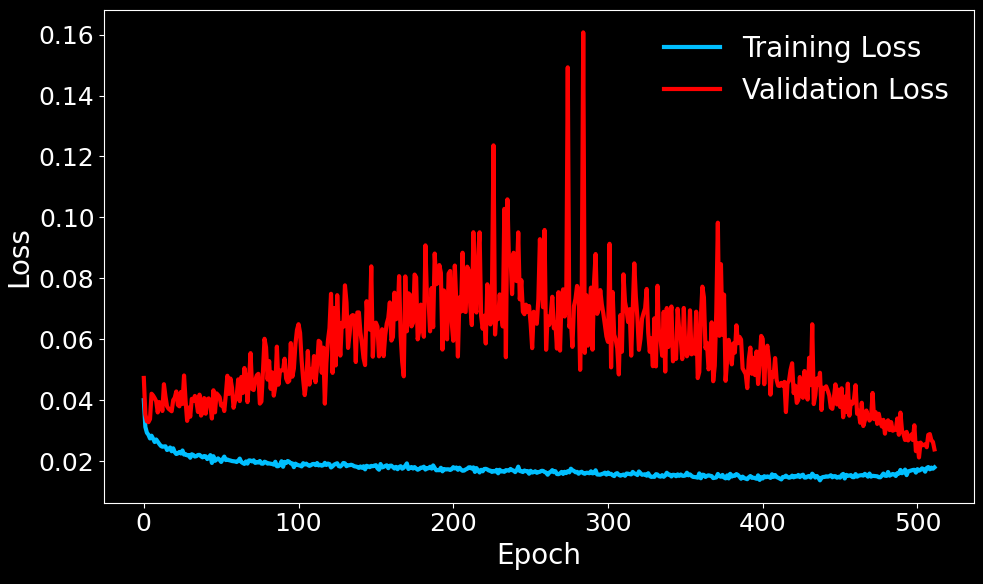

In [7]:
trainer.display_results()

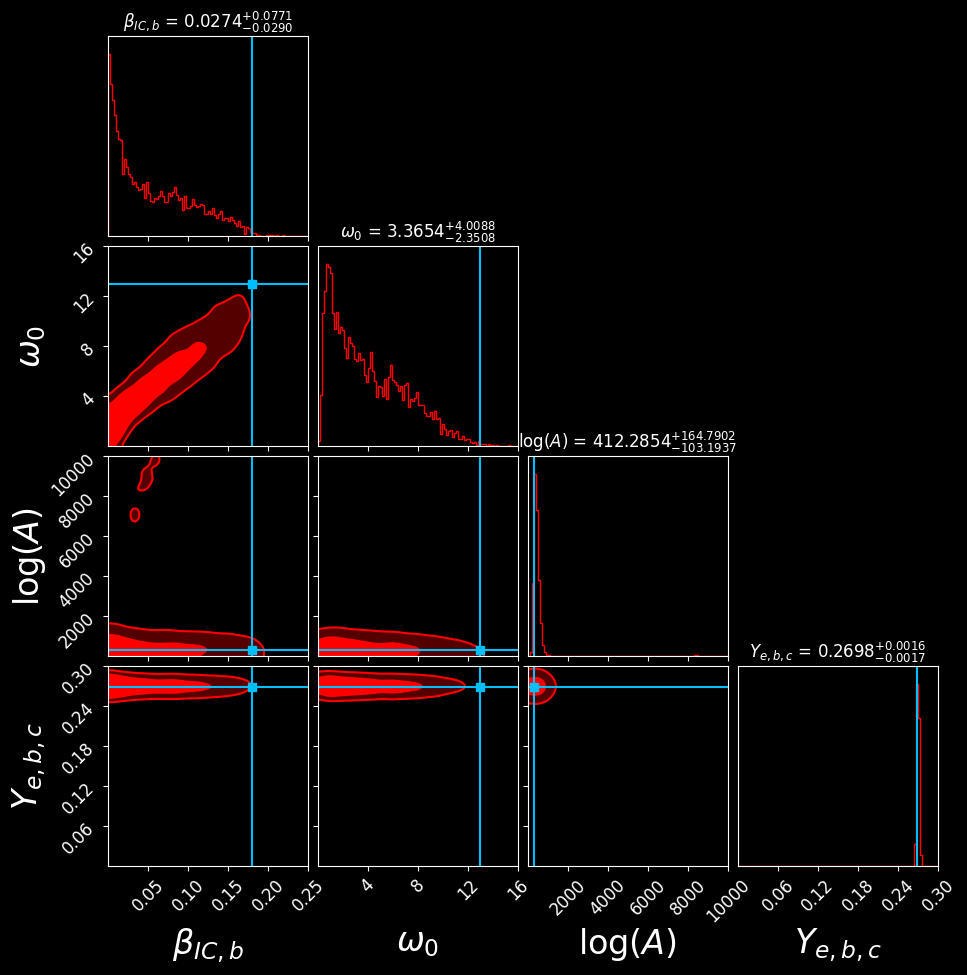

In [8]:
# trainer.val_loader.dataset.update_snr(20)
# signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(9)
# plot_candidate_signal(noisy_signal=noisy_signal/TEN_KPC, signal=signal/TEN_KPC, max_value=trainer.validation_dataset.max_strain, fname="plots/detected_signal.svg", background="black")
trainer.plot_corner(index=1, fname="plots/corner_plot.svg")

Number of parameters: 4


/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_15535/2591236404.py:104: UserWarning: Glyph 946 (\N{GREEK SMALL LETTER BETA}) missing from font(s) Avenir.
  plt.tight_layout()
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_15535/2591236404.py:104: UserWarning: Glyph 969 (\N{GREEK SMALL LETTER OMEGA}) missing from font(s) Avenir.
  plt.tight_layout()
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_15535/2591236404.py:104: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Avenir.
  plt.tight_layout()
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_15535/2591236404.py:104: UserWarning: Glyph 8337 (\N{LATIN SUBSCRIPT SMALL LETTER E}) missing from font(s) Avenir.
  plt.tight_layout()
/var/folders/qy/p5knypnd54x1dfyxqbs0175r0000gn/T/ipykernel_15535/2591236404.py:105: UserWarning: Glyph 946 (\N{GREEK SMALL LETTER BETA}) missing from font(s) Avenir.
  plt.savefig(fname, dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
/va

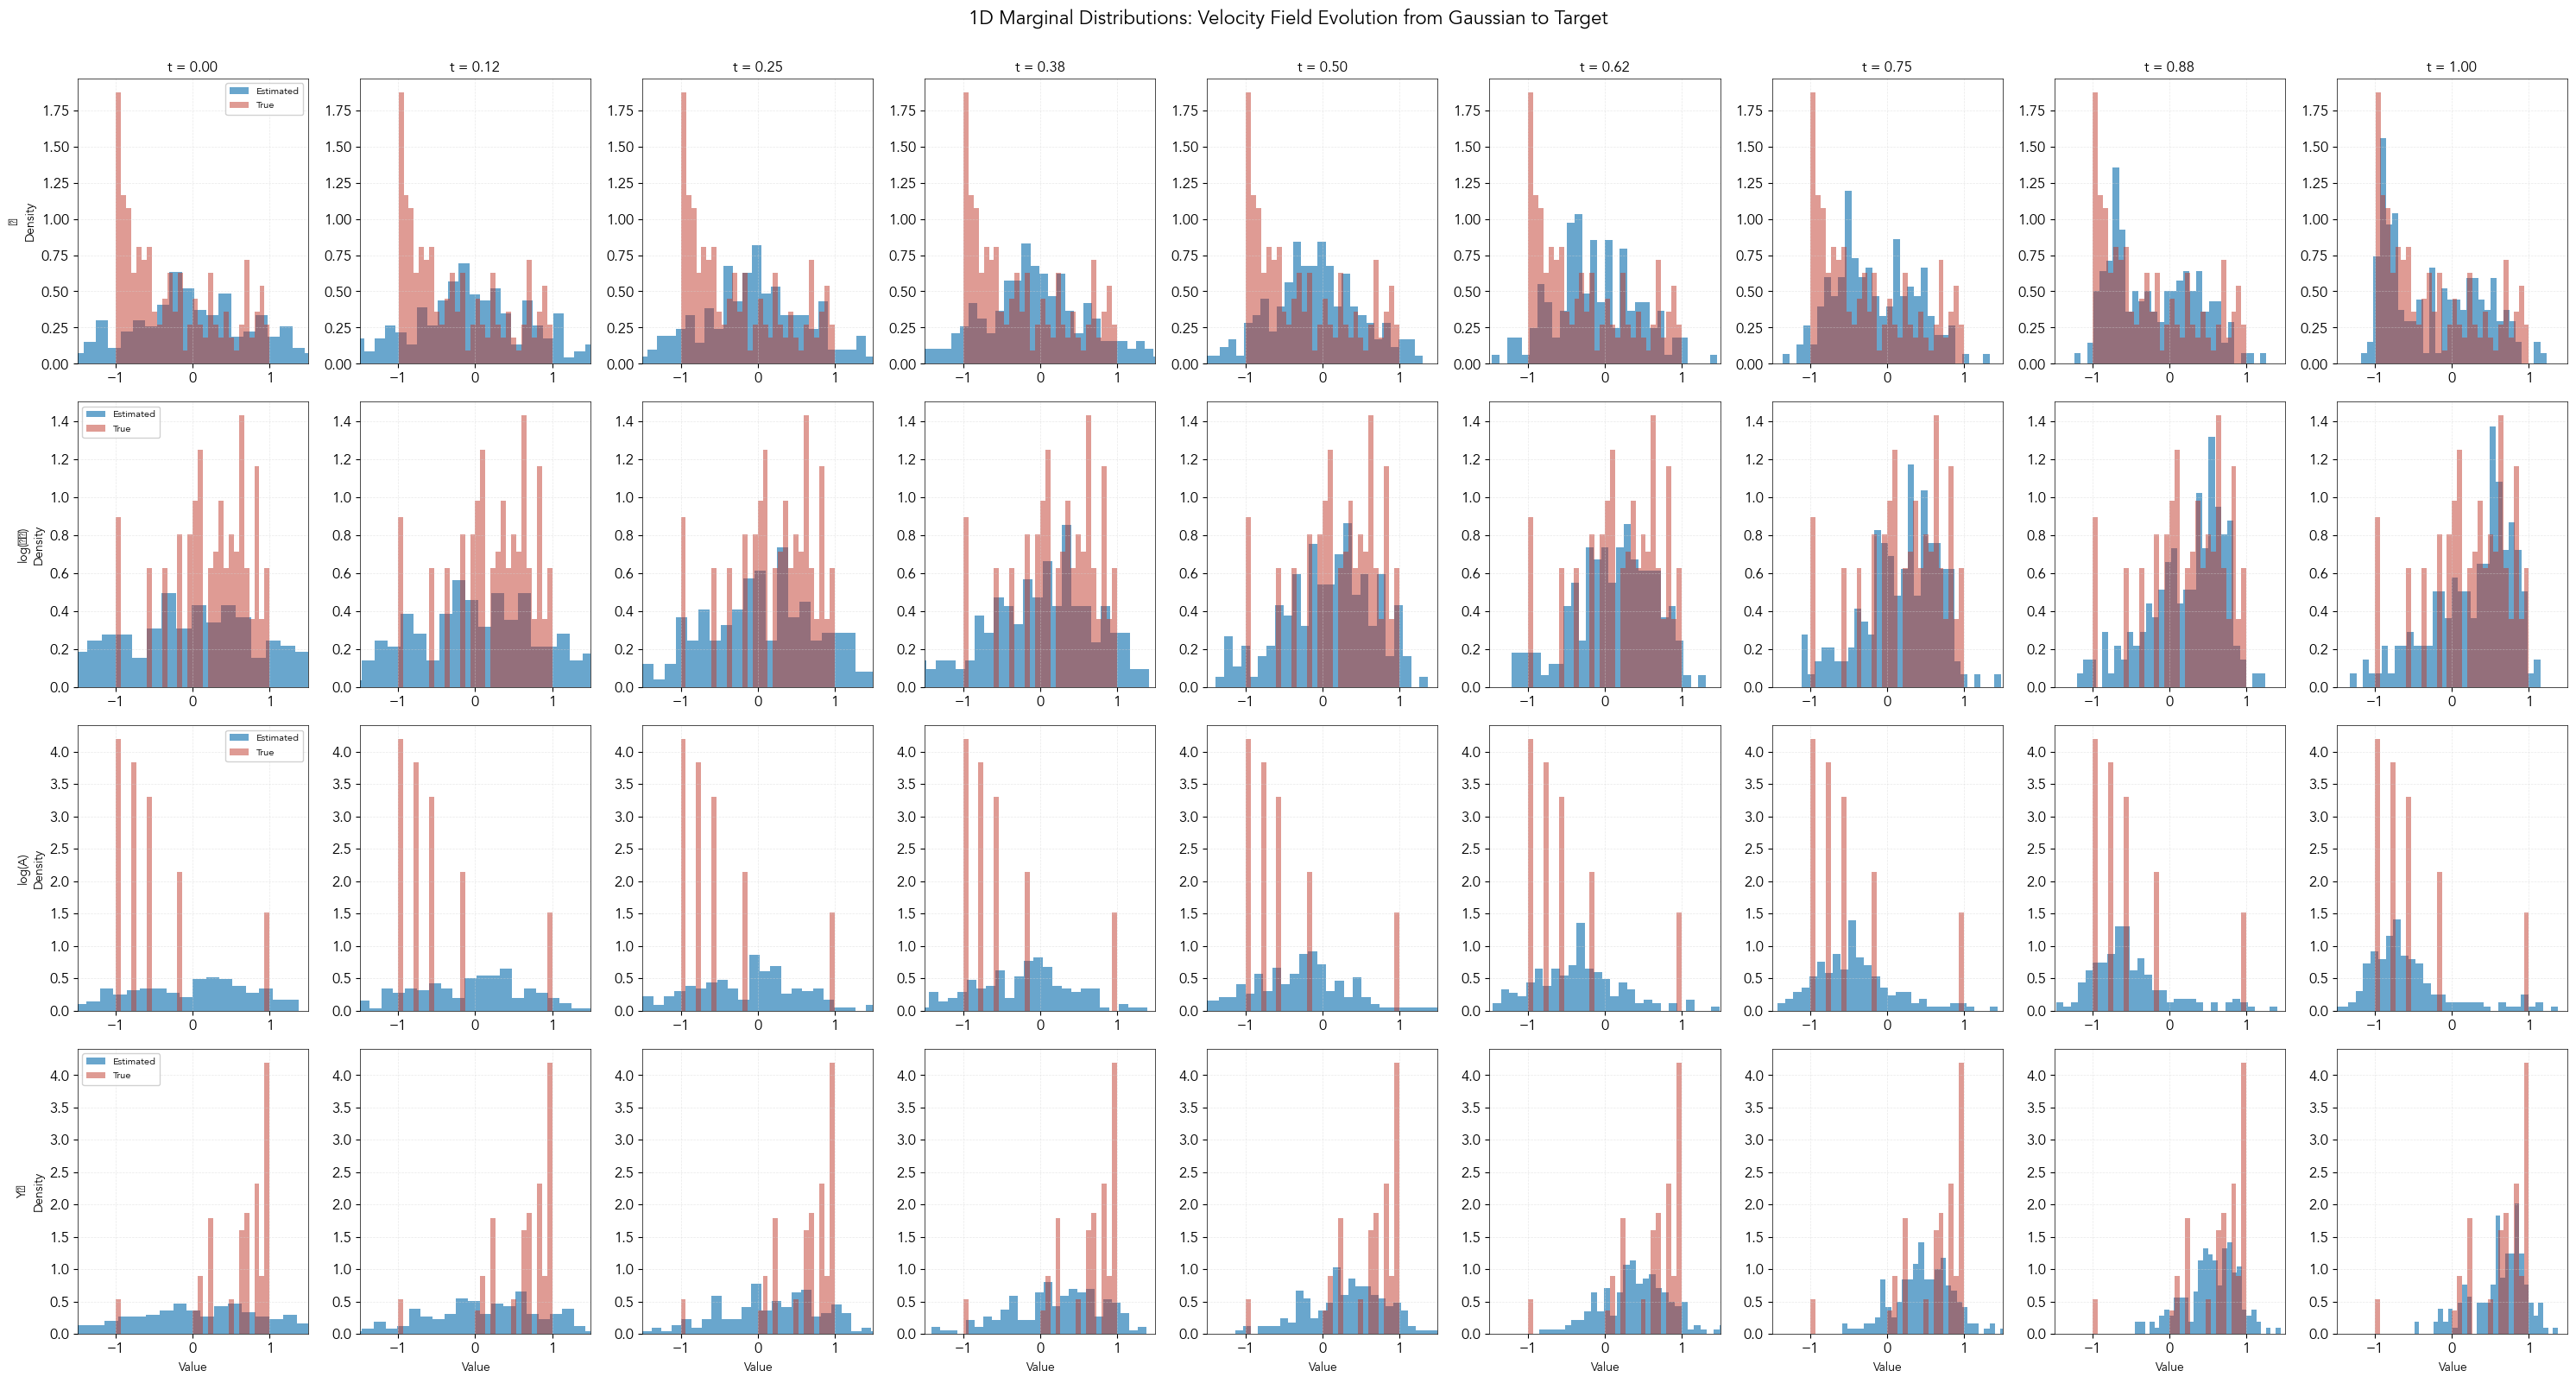

In [9]:
def plot_velocity_field_evolution(trainer, n_test_samples=300, n_steps=8, background="white", fname="plots/flow_evolution_1d_marginals.png"):
    """
    Visualize the evolution of parameter distributions through the velocity field.
    
    Args:
        trainer: FlowMatchingTrainer instance
        n_test_samples: Number of test samples to use
        n_steps: Number of flow steps to visualize
        background: "white" or "black" for plot styling
        fname: Filename to save the plot
    """
    from starccato_flow.plotting.plotting import set_plot_style
    
    # Set plot style based on background
    set_plot_style(background=background, font_family="sans-serif", font_name="Avenir")
    
    val_dataset = trainer.val_loader.dataset
    
    # Get true parameters and signals from validation set
    n_test_samples = min(n_test_samples, len(val_dataset))
    
    # Detect number of parameters dynamically
    sample_signal, sample_noisy, sample_params = val_dataset[0]
    num_params = sample_params.shape[-1]
    print(f"Number of parameters: {num_params}")
    
    true_params = torch.zeros(n_test_samples, num_params, device=DEVICE)
    test_signals = torch.zeros(n_test_samples, trainer.y_length, device=DEVICE)
    
    for i in range(n_test_samples):
        clean_signal, noisy_signal, params = val_dataset[i]
        true_params[i] = params.squeeze()
        test_signals[i] = noisy_signal.squeeze()
    
    # Start from noise in parameter space (independent 1D Gaussians)
    x = torch.randn(n_test_samples, num_params, device=DEVICE)
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    # Store snapshots for visualization
    snapshots = [x.detach().cpu().clone()]
    
    # Flow the samples
    for i in range(n_steps):
        x = trainer.flow.step(x, time_steps[i], time_steps[i + 1], test_signals)
        snapshots.append(x.detach().cpu().clone())
    
    # Visualize 1D marginal distributions evolving
    param_names = ['β', 'log(ω₀)', 'log(A)', 'Yₑ'] if num_params == 4 else ['Param 1', 'Param 2']
    
    # Color scheme based on background
    if background == "black":
        estimated_color = '#3498db'  # Blue
        true_color = '#e74c3c'  # Red
        text_color = 'white'
        grid_color = 'gray'
        grid_alpha = 0.3
    else:
        estimated_color = '#2980b9'  # Darker blue
        true_color = '#c0392b'  # Darker red
        text_color = 'black'
        grid_color = 'lightgray'
        grid_alpha = 0.5
    
    fig, axes = plt.subplots(num_params, n_steps + 1, figsize=(30, 4*num_params))
    if num_params == 1:
        axes = axes.reshape(1, -1)
    
    for param_idx in range(num_params):
        for step_idx, snapshot in enumerate(snapshots):
            ax = axes[param_idx, step_idx]
            
            # Plot histogram of this parameter dimension
            ax.hist(snapshot[:, param_idx].numpy(), bins=30, alpha=0.7, 
                    color=estimated_color, density=True, label='Estimated', edgecolor='none')
            ax.hist(true_params.cpu()[:, param_idx].numpy(), bins=30, alpha=0.5, 
                    color=true_color, density=True, label='True', edgecolor='none')
            
            if param_idx == 0:
                ax.set_title(f't = {time_steps[step_idx]:.2f}', fontsize=12, color=text_color)
            if step_idx == 0:
                ax.set_ylabel(f'{param_names[param_idx]}\nDensity', fontsize=10, color=text_color)
            if param_idx == num_params - 1:
                ax.set_xlabel('Value', fontsize=10, color=text_color)
            
            # Set x-limits based on parameter type
            if num_params == 4:
                ax.set_xlim(-1.5, 1.5)  # Normalized parameters
            else:
                ax.set_xlim(-1.5, 1.5)  # Normalized toy parameters
            
            if step_idx == 0:
                ax.legend(fontsize=8, framealpha=0.9)
            
            # Grid
            ax.grid(True, alpha=grid_alpha, color=grid_color, linestyle='--', linewidth=0.5)
            
            # Spine colors
            for spine in ax.spines.values():
                spine.set_edgecolor(text_color)
                spine.set_linewidth(0.5)
    
    title_text = '1D Marginal Distributions: Velocity Field Evolution from Gaussian to Target'
    plt.suptitle(title_text, fontsize=16, y=1.00, color=text_color)
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

# Call the function
plot_velocity_field_evolution(trainer, n_test_samples=300, n_steps=8, background="white", 
                               fname="plots/flow_evolution_1d_marginals.png")

In [10]:
# Diagnostic: Check if signals are different
for idx in [0, 10, 50]:
    signal, noisy_signal, params = trainer.val_loader.dataset[idx]
    print(f"\n=== Signal {idx} ===")
    print(f"Signal shape: {noisy_signal.shape}")
    print(f"Signal mean: {noisy_signal.mean():.6f}, std: {noisy_signal.std():.6f}")
    print(f"Signal min: {noisy_signal.min():.6f}, max: {noisy_signal.max():.6f}")
    print(f"True params (normalized): {params.flatten()}")
    print(f"True params (denormalized): {trainer.val_loader.dataset.denormalize_parameters(params.reshape(1, -1)).flatten()}")


=== Signal 0 ===
Signal shape: torch.Size([1, 256])
Signal mean: -0.000245, std: 0.065514
Signal min: -0.207186, max: 0.203177
True params (normalized): tensor([-0.5694,  0.2797, -0.7476,  1.0000], device='mps:0')


/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:78: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (
/Users/tarineccleston/Desktop/starccato/starccato-flow/src/starccato_flow/data/ccsn_snr_data.py:78: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert (


AttributeError: 'Tensor' object has no attribute 'copy'